**Optimization Based Index Enhancement Method for S&P 500 Stock Selection**


In [ ]:
import pandas as pd
import requests
import numpy as np
import yfinance as yf
import os
from tqdm import tqdm
import time
from pathlib import Path
import pyomo.environ as pyo
import shutil
import matplotlib.pyplot as plt

In [ ]:
print("HiGHS available? ", pyo.SolverFactory("appsi_highs").available())

HiGHS available?  True


In [ ]:
# retrieves and preprocesses the S&P 500 constituents
CSV_PATH = "sp500_constituents.csv"

def fetch_sp500_from_wikipedia() -> pd.DataFrame:
    """Return a cleaned constituents table with at least: Symbol, Security, GICS Sector."""
    url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    headers = {
        "User-Agent": ("Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                       "AppleWebKit/537.36 (KHTML, like Gecko) "
                       "Chrome/118.0.0.0 Safari/537.36")
    }
    html = requests.get(url, headers=headers, timeout=20).text
    tables = pd.read_html(html)

    # pick a table that has a 'symbol' column; otherwise fall back to the first table
    df = None
    for t in tables:
        cols = [str(c).strip() for c in t.columns]
        if any("symbol" in c.lower() for c in cols):
            df = t.copy()
            df.columns = cols
            break
    if df is None:
        df = tables[0].copy()
        df.columns = [str(c).strip() for c in df.columns]

    # standardize key column names
    rename = {}
    for c in df.columns:
        cl = str(c).strip().lower()
        if "symbol" in cl:
            rename[c] = "Symbol"
        elif "security" in cl or "company" in cl:
            rename[c] = "Security"
        elif "gics" in cl and "sector" in cl:
            rename[c] = "GICS Sector"
        elif "gics" in cl and "sub" in cl:
            rename[c] = "GICS Sub-Industry"
    df = df.rename(columns=rename)

    # clean symbols
    if "Symbol" not in df.columns:
        first_col = df.columns[0]
        df = df.rename(columns={first_col: "Symbol"})
    df["Symbol"] = df["Symbol"].astype(str).str.strip()
    df = df[df["Symbol"].ne("")]
    keep = [c for c in ["Symbol", "Security", "GICS Sector", "GICS Sub-Industry"] if c in df.columns]
    return df[keep] if keep else df

# 1) ensure we have a local CSV
if os.path.exists(CSV_PATH):
    sp500 = pd.read_csv(CSV_PATH)
    sp500.columns = [str(c).strip() for c in sp500.columns]
    print(f"Loaded constituents: {len(sp500)} from {CSV_PATH}")
else:
    sp500 = fetch_sp500_from_wikipedia()
    sp500.to_csv(CSV_PATH, index=False)
    print(f"Saved constituents: {len(sp500)} to {CSV_PATH}")

# 2) build Yahoo tickers and sector one-hot
sp500["YahooTicker"] = sp500["Symbol"].astype(str).str.strip().str.replace(".", "-", regex=False)
sector_onehot = pd.get_dummies(
    sp500.set_index("YahooTicker")["GICS Sector"].astype(str),
    dtype=float
)

# 3) export these for downstream cells
universe = list(sector_onehot.index)
S = sector_onehot.to_numpy(dtype=float)

print("universe =", len(universe), "| S shape =", S.shape, "| #sectors =", sector_onehot.shape[1])

/tmp/ipython-input-594093277.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


Saved constituents: 503 to sp500_constituents.csv
universe = 503 | S shape = (503, 11) | #sectors = 11


In [ ]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"


headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/118.0.0.0 Safari/537.36"}

html = requests.get(url, headers=headers).text
tables = pd.read_html(html)
sp500 = tables[0]
sp500.head()




/tmp/ipython-input-1047173213.py:10: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


,0,1
0,NaN,This article contains one or more duplicated c...


In [ ]:
# 0) Make a copy and force string column names (avoid int/tuple keys)
sp500 = sp500.copy()
sp500.columns = [str(c).strip() for c in sp500.columns]

sym_candidates = [c for c in sp500.columns
                  if any(k in c.lower() for k in ["symbol", "ticker", "code"])]
symbol_col = sym_candidates[0] if sym_candidates else sp500.columns[0]


sec_candidates = [c for c in sp500.columns
                  if ("gics" in c.lower() and "sector" in c.lower()) or c.lower() == "sector"]
sector_col = sec_candidates[0] if sec_candidates else None

tickers_y = sp500[symbol_col].astype(str).str.strip().str.replace(".", "-", regex=False)

if sector_col is None:
    print("Warning: sector column not found. Using a single 'Unknown' sector.")
    sector_series = pd.Series("Unknown", index=tickers_y)
    sector_onehot = pd.get_dummies(sector_series, dtype=float)
else:
    sector_series = sp500[sector_col].astype(str).str.strip()
    sector_onehot = pd.get_dummies(sector_series, dtype=float)
    sector_onehot.index = tickers_y  # align rows to tickers

if "universe" not in globals():
    universe = tickers_y.tolist()

sector_onehot = sector_onehot.reindex(index=universe, fill_value=0.0)
S = sector_onehot.to_numpy(dtype=float)

print("Columns(head):", list(sp500.columns)[:6])
print("Detected -> symbol_col:", symbol_col, " sector_col:", sector_col)
print("S shape:", S.shape, " | #sectors:", sector_onehot.shape[1])

Columns(head): ['0', '1']
Detected -> symbol_col: 0  sector_col: None
S shape: (503, 1)  | #sectors: 1


In [ ]:
# Robust extractor: find the constituents table and normalize column names
def extract_sp500_table(tables):
    # Search tables that look like the constituents table
    candidates = []
    for df in tables:
        cols_norm = [str(c).strip().lower() for c in df.columns]
        has_symbol = any(("symbol" in c) or ("ticker" in c) for c in cols_norm)
        has_sector = any(("gics" in c) and ("sector" in c) for c in cols_norm)
        if has_symbol and has_sector:
            candidates.append(df.copy())

    if candidates:
        df = candidates[0]
    else:
        df = max(tables, key=lambda x: (x.shape[0], x.shape[1])).copy()

    rename = {}
    for c in df.columns:
        cl = str(c).strip().lower()
        if ("symbol" in cl) or ("ticker" in cl):
            rename[c] = "Symbol"
        elif cl == "security" or "company" in cl:
            rename[c] = "Security"
        elif ("gics" in cl) and ("sector" in cl):
            rename[c] = "GICS Sector"
        elif ("gics" in cl) and ("sub" in cl):
            rename[c] = "GICS Sub-Industry"
    df = df.rename(columns=rename)

    if "Symbol" not in df.columns:
        first_col = df.columns[0]
        df = df.rename(columns={first_col: "Symbol"})

    df["Symbol"] = df["Symbol"].astype(str).str.strip()
    df = df[df["Symbol"].ne("")]
    keep = [c for c in ["Symbol", "Security", "GICS Sector", "GICS Sub-Industry"] if c in df.columns]
    return df[keep] if keep else df

sp500 = extract_sp500_table(tables)
sp500.head(), sp500.columns.tolist()

(  Symbol             Security             GICS Sector  \
 0    MMM                   3M             Industrials   
 1    AOS          A. O. Smith             Industrials   
 2    ABT  Abbott Laboratories             Health Care   
 3   ABBV               AbbVie             Health Care   
 4    ACN            Accenture  Information Technology   
 
                 GICS Sub-Industry  
 0        Industrial Conglomerates  
 1               Building Products  
 2           Health Care Equipment  
 3                   Biotechnology  
 4  IT Consulting & Other Services  ,
 ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry'])

In [ ]:
sp500["YahooTicker"] = sp500["Symbol"].str.replace(".", "-", regex=False)

# Build sector one-hot (GICS Level-1) indexed by Yahoo tickers
sector_map = sp500.set_index("YahooTicker")["GICS Sector"]
sector_onehot = pd.get_dummies(sector_map)
sector_onehot.head()

if Path("sp500_prices_2020_2025.pkl").exists():
    data = pd.read_pickle("sp500_prices_2020_2025.pkl")
else:
    tickers = list(sector_onehot.index)
    data = yf.download(
        tickers,
        start="2020-01-01",
        end="2025-01-01",
        group_by="ticker",
        auto_adjust=True,
        threads=True,)

[*********************100%***********************]  503 of 503 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['SOLS', 'Q']: YFPricesMissingError('possibly delisted; no price data found  (1d 2020-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1577854800, endDate = 1735707600")')


In [ ]:
# Clean column names to Yahoo style and extract Close matrix
if not isinstance(data.columns, pd.MultiIndex):
    raise ValueError("Expected MultiIndex columns from yfinance (group_by='ticker').")

top = data.columns.get_level_values(0).astype(str).str.replace(".", "-", regex=False)
fld = data.columns.get_level_values(1).astype(str)
data.columns = pd.MultiIndex.from_arrays([top, fld])
fields = set(fld)
price_field = "Close" if "Close" in fields else ("Adj Close" if "Adj Close" in fields else None)
if price_field is None:
    raise KeyError("Neither 'Close' nor 'Adj Close' found in downloaded data.")


close = data.xs(price_field, axis=1, level=1).sort_index(axis=1)
universe = sorted(set(close.columns).intersection(set(sector_onehot.index)))
close = close[universe].ffill().dropna(how="all")

print("universe size:", len(universe), "| close shape:", close.shape, "| field used:", price_field)

universe size: 503 | close shape: (1258, 503) | field used: Close


In [ ]:
assert all(k in globals() for k in ["sp500", "sector_onehot", "universe"]), \
    "Run the constituents cell above (it creates sp500/sector_onehot/universe)."

sector_onehot = sector_onehot.reindex(universe, fill_value=0.0)
S = sector_onehot.to_numpy(dtype=float)

print("OK – using prebuilt constituents.")
print("universe:", len(universe), "| S shape:", S.shape, "| #sectors:", sector_onehot.shape[1])
sector_onehot.head()

OK – using prebuilt constituents.
universe: 503 | S shape: (503, 11) | #sectors: 11


,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
YahooTicker,,,,,,,,,,,
A,False,False,False,False,False,True,False,False,False,False,False
AAPL,False,False,False,False,False,False,False,True,False,False,False
ABBV,False,False,False,False,False,True,False,False,False,False,False
ABNB,False,True,False,False,False,False,False,False,False,False,False
ABT,False,False,False,False,False,True,False,False,False,False,False


In [ ]:
# 12-1 momentum
mom = close.shift(21) / close.shift(252) - 1  # exclude most recent month

def zscore_row(row: pd.Series) -> pd.Series:
    m = row.mean(skipna=True)
    sd = row.std(skipna=True, ddof=0)
    if sd == 0 or np.isnan(sd):
        return row*0.0
    return (row - m) / sd

f = mom.apply(zscore_row, axis=1)
alpha = 0.0004
mu_panel = (alpha * f).fillna(0.0)
mu_panel.shape

N = len(universe)
b = np.ones(N) / N

assert S.shape[0] == len(universe)
assert S.shape[1] >= 1
S.shape

(503, 11)

In [ ]:
# Build month-end trading-day endpoints
last_days = close.index.to_series().groupby(pd.Grouper(freq="M")).max()
rebalance_days = last_days.values[:-1]   # trading-day timestamps
holdto_days   = last_days.values[1:]

N = len(universe)
coverage = mom.reindex(rebalance_days).notna().mean(axis=1)
start_idx = int(np.argmax(coverage.values >= 0.80))          # first month meeting threshold

print("First valid rebalance day:", rebalance_days[start_idx],
      "| coverage =", f"{coverage.iloc[start_idx]:.1%}")

First valid rebalance day: 2020-12-31T00:00:00.000000000 | coverage = 96.6%


/tmp/ipython-input-783714234.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last_days = close.index.to_series().groupby(pd.Grouper(freq="M")).max()


In [ ]:
# build optimization model
def solve_lp(mu_vec, b_vec, S_mat, w_prev,
             delta=0.01, tau=0.20, gamma_sector=0.02, c=0.0005,
             solver_name="highs"):
    """
    Solve one-period LP:
        max mu^T w - c * sum t
        s.t. sum w = 1
             max(0, b_i - delta) <= w_i <= min(0.10, b_i + delta)
             sector exposures within ±gamma_sector of benchmark
             t_i >= ±(w_i - w_prev_i); sum t <= tau
             w_i, t_i >= 0
    Returns:
        w (np.array), t (np.array), solver_result
    """
    n = len(mu_vec)
    k = S_mat.shape[1]
    sbmk = S_mat.T @ b_vec

    m = pyo.ConcreteModel()
    m.I = range(n)
    m.J = range(k)

    m.w = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.t = pyo.Var(m.I, domain=pyo.NonNegativeReals)

    m.obj = pyo.Objective(
        expr=sum(mu_vec[i]*m.w[i] for i in m.I) - c*sum(m.t[i] for i in m.I),
        sense=pyo.maximize)

    m.full = pyo.Constraint(expr=sum(m.w[i] for i in m.I) == 1)

    # Stock-level bounds + turnover linearization
    m.cli = pyo.ConstraintList()
    for i in m.I:
        lb = max(0.0, b_vec[i] - delta)
        ub = min(0.10, b_vec[i] + delta)
        m.cli.add(m.w[i] >= lb)
        m.cli.add(m.w[i] <= ub)
        m.cli.add(m.t[i] >= m.w[i] - w_prev[i])
        m.cli.add(m.t[i] >= -(m.w[i] - w_prev[i]))

    # Sector exposure bounds (two-sided)
    m.sec_up = pyo.ConstraintList()
    m.sec_dn = pyo.ConstraintList()
    for j in m.J:
        m.sec_up.add(sum(S_mat[i, j]*m.w[i] for i in m.I) - sbmk[j] <= gamma_sector)
        m.sec_dn.add(-(sum(S_mat[i, j]*m.w[i] for i in m.I) - sbmk[j]) <= gamma_sector)

    # Turnover cap
    m.turncap = pyo.Constraint(expr=sum(m.t[i] for i in m.I) <= tau)

    opt = pyo.SolverFactory(solver_name)
    if (not opt.available()) and solver_name != "glpk":
        opt = pyo.SolverFactory("glpk")
    res = opt.solve(m, tee=False)

    w = np.array([pyo.value(m.w[i]) for i in m.I])
    t = np.array([pyo.value(m.t[i]) for i in m.I])
    return w, t, res

In [ ]:
d0      = rebalance_days[start_idx]
d0_next = holdto_days[start_idx]

mu0 = mu_panel.loc[d0, universe].fillna(0.0).to_numpy()
w_prev0 = b.copy()

w0, t0, res0 = solve_lp(mu0, b, S, w_prev0,
                        delta=0.01, tau=0.20,
                        gamma_sector=0.02, c=0.0005,
                        solver_name="appsi_highs")

r_next_vec = close.loc[d0_next, universe] / close.loc[d0, universe] - 1.0
r_next = r_next_vec.to_numpy()
mask = np.isfinite(r_next)
w_eff = w0.copy(); w_eff[~mask] = 0.0
s = w_eff.sum()
if s > 0: w_eff /= s
port_ret0 = float((w_eff * np.nan_to_num(r_next, nan=0.0)).sum())

w_ser = pd.Series(w0, index=universe)
active = w_ser - pd.Series(b, index=universe)
print("d0 =", d0, "-> hold to", d0_next, " one-period return =", round(port_ret0, 6))
print("Sum(w) =", float(w_ser.sum()))
print("\nTop weights:\n", w_ser.sort_values(ascending=False).head(10))
print("\nTop overweights:\n", active.sort_values(ascending=False).head(10))
print("\nTop underweights:\n", active.sort_values().head(10))

d0 = 2020-12-31T00:00:00.000000000 -> hold to 2021-01-29T00:00:00.000000000  one-period return = 0.002819
Sum(w) = 0.9999999999999913

Top weights:
 DDOG    0.011988
XYZ     0.011988
NVDA    0.011988
TTD     0.011988
CRWD    0.011988
TSLA    0.011988
GNRC    0.011988
MRNA    0.011988
MPWR    0.001988
MRK     0.001988
dtype: float64

Top overweights:
 DDOG    0.01
XYZ     0.01
NVDA    0.01
TTD     0.01
CRWD    0.01
TSLA    0.01
GNRC    0.01
MRNA    0.01
MPWR    0.00
MRK     0.00
dtype: float64

Top underweights:
 USB    -0.001988
TSN    -0.001988
UAL    -0.001988
TKO    -0.001988
RTX    -0.001988
TRGP   -0.001988
SLB    -0.001988
SPG    -0.001988
OXY    -0.001988
RCL    -0.001988
dtype: float64


In [ ]:
print("Turnover this period =", float(t0.sum()))
K = S.shape[1]
sector_names = sector_onehot.columns.tolist() if 'sector_onehot' in globals() else [f"S{j}" for j in range(K)]
sbmk = S.T @ b                  # benchmark sector weights (K,)
sexp = (S.T @ w0)               # portfolio sector weights (K,)
dev  = pd.Series(sexp - sbmk, index=sector_names).sort_values(key=abs, ascending=False)
print("\nLargest abs sector deviations:\n", dev.head(10))

Turnover this period = 0.16000000000000864

Largest abs sector deviations:
 Information Technology    0.020000
Energy                   -0.020000
Real Estate              -0.008250
Health Care               0.008012
Communication Services    0.008012
Financials               -0.003917
Utilities                -0.001988
Consumer Staples         -0.001988
Consumer Discretionary    0.000060
Industrials               0.000060
dtype: float64


Annualized return = 19.9861% | Vol = 18.8566% | IR = 1.06
Avg monthly turnover = 7.36%  (median 6.80%)


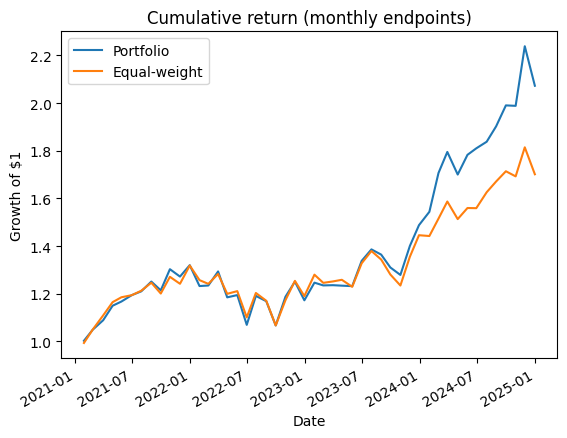

In [ ]:
weights_rows, port_rets, turnovers = [], [], []
w_prev = b.copy()

for d, d_next in zip(rebalance_days[start_idx:], holdto_days[start_idx:]):
    mu = mu_panel.loc[d, universe].fillna(0.0).to_numpy()
    w, t, _ = solve_lp(mu, b, S, w_prev,
                       delta=0.01, tau=0.20,
                       gamma_sector=0.02, c=0.0005,
                       solver_name="appsi_highs")

    r_next_vec = close.loc[d_next, universe] / close.loc[d, universe] - 1.0
    r_next = r_next_vec.to_numpy()
    m = np.isfinite(r_next)
    w_eff = w.copy(); w_eff[~m] = 0.0
    s = w_eff.sum()
    if s > 0: w_eff /= s

    port_rets.append((d_next, float((w_eff * np.nan_to_num(r_next, nan=0.0)).sum())))
    turnovers.append((d, float(t.sum())))
    weights_rows.append(pd.Series(w, index=universe, name=d))
    w_prev = w

W    = pd.DataFrame(weights_rows)
perf = pd.DataFrame(port_rets, columns=["date","port_ret"]).set_index("date")
perf["cum"] = (1.0 + perf["port_ret"]).cumprod()
turnover_s = pd.Series(dict(turnovers))

bench_seq = []
for d, d_next in zip(rebalance_days[start_idx:], holdto_days[start_idx:]):
    r_next_vec = close.loc[d_next, universe] / close.loc[d, universe] - 1.0
    r_next = r_next_vec.to_numpy()
    m = np.isfinite(r_next)
    bench_seq.append(np.nanmean(r_next[m]) if m.any() else 0.0)
bench_ser = pd.Series(bench_seq, index=holdto_days[start_idx:])
bench_cum = (1.0 + bench_ser).cumprod()

# summary stats
mret = perf["port_ret"]
ann = (1.0 + mret).prod()**(12/len(mret)) - 1.0
vol = mret.std(ddof=0) * np.sqrt(12)
ir  = ann / vol if vol > 0 else np.nan
print(f"Annualized return = {ann:.4%} | Vol = {vol:.4%} | IR = {ir:.2f}")
print(f"Avg monthly turnover = {float(turnover_s.mean()):.2%}  (median {float(turnover_s.median()):.2%})")

plt.figure()
perf["cum"].plot()
bench_cum.plot()
plt.legend(["Portfolio","Equal-weight"], loc="best")
plt.title("Cumulative return (monthly endpoints)")
plt.xlabel("Date"); plt.ylabel("Growth of $1"); plt.show()

# save artifacts
perf.to_csv("perf_monthly.csv")
W.to_csv("weights_monthly.csv")
turnover_s.to_csv("turnover_monthly.csv")

In [ ]:
idx_reb  = pd.DatetimeIndex(rebalance_days[start_idx:])
idx_hold = pd.DatetimeIndex(holdto_days[start_idx:])
n = min(len(idx_reb), len(idx_hold))
idx_reb  = idx_reb[:n]
idx_hold = idx_hold[:n]


buf_days = 7
spx_df = yf.download(
    "^GSPC",
    start=(idx_reb.min()  - pd.Timedelta(days=buf_days)).strftime("%Y-%m-%d"),
    end  =(idx_hold.max() + pd.Timedelta(days=buf_days)).strftime("%Y-%m-%d"),
    auto_adjust=True,
    progress=False,)


close_cols = [c for c in ["Close", "Adj Close", "close", "adjclose"] if c in spx_df.columns]
if not close_cols:
    raise RuntimeError(f"No close-like column in SPX data. Columns={list(spx_df.columns)}")
spx_close = spx_df[close_cols[0]]
if isinstance(spx_close, pd.DataFrame):
    spx_close = spx_close.iloc[:, 0]
spx_close = spx_close.dropna().astype(float)
spx_start_ser = spx_close.reindex(idx_reb,  method="pad")
spx_end_ser   = spx_close.reindex(idx_hold, method="pad")

start_vals = spx_start_ser.to_numpy(dtype=float)
end_vals   = spx_end_ser.to_numpy(dtype=float)

mask = np.isfinite(start_vals) & np.isfinite(end_vals)
spx_ret_vals = end_vals[mask] / start_vals[mask] - 1.0
spx_ser = pd.Series(spx_ret_vals, index=idx_hold[mask], name="spx_ret")


port_ser = perf["port_ret"]
if isinstance(port_ser, pd.DataFrame):
    port_ser = port_ser.iloc[:, 0]
port_ser = port_ser.astype(float).reindex(spx_ser.index)

active = (port_ser - spx_ser).dropna()

if active.empty:
    print("No overlapping months after alignment.")
    print("our window:", idx_reb.min().date(), "→", idx_hold.max().date())
    print("spx window:", spx_close.index.min().date(), "→", spx_close.index.max().date())
else:
    te  = active.std(ddof=0) * np.sqrt(12)
    ar  = (1.0 + active).prod()**(12/len(active)) - 1.0
    air = ar / te if te > 0 else np.nan
    print(f"Active return (ann) = {ar:.4%} | TE (ann) = {te:.4%} | Active IR = {air:.2f}")

    out = pd.DataFrame({"port_ret": port_ser.reindex(active.index),
                        "spx_ret": spx_ser.reindex(active.index)})
    out["active"] = out["port_ret"] - out["spx_ret"]
    out.to_csv("tracking_series.csv")
    print("Saved -> tracking_series.csv")

Active return (ann) = 7.6162% | TE (ann) = 6.8418% | Active IR = 1.11
Saved -> tracking_series.csv


**Parameter Grid Experiment**

In [ ]:
# single period grid search over parameters
grid_delta   = [0.005, 0.010, 0.020]
grid_tau     = [0.10, 0.20, 0.30]
grid_gamma   = [0.01, 0.02]
grid_cost    = [0.0003, 0.0005]

results = []

for delta in grid_delta:
    for tau in grid_tau:
        for gamma in grid_gamma:
            for c in grid_cost:

                # solve LP for this parameter set
                w, t, _ = solve_lp(
                    mu0, b, S, w_prev0,
                    delta=delta, tau=tau,
                    gamma_sector=gamma, c=c,
                    solver_name="appsi_highs"
                )


                obj_val = float(mu0 @ w - c * t.sum())
                turnover = float(t.sum())
                sbmk  = S.T @ b
                sexp  = S.T @ w
                max_dev = float(np.max(np.abs(sexp - sbmk)))

                lb = np.maximum(0.0, b - delta)
                ub = np.minimum(0.10, b + delta)
                at_lb = np.isclose(w, lb, atol=1e-6).sum()
                at_ub = np.isclose(w, ub, atol=1e-6).sum()
                num_bounds = int(at_lb + at_ub)

                r_next_vec = close.loc[d0_next, universe] / close.loc[d0, universe] - 1
                r_next = r_next_vec.to_numpy()
                mask = np.isfinite(r_next)
                w_eff = w.copy()
                w_eff[~mask] = 0.0
                if w_eff.sum() > 0:
                    w_eff /= w_eff.sum()
                realized_ret = float((w_eff * np.nan_to_num(r_next, nan=0.0)).sum())

                results.append({
                    "delta": delta,
                    "tau": tau,
                    "gamma_sector": gamma,
                    "cost_c": c,
                    "objective": obj_val,
                    "turnover": turnover,
                    "max_sector_dev": max_dev,
                    "num_bounds": num_bounds,
                    "realized_return": realized_ret
                })


grid_df = pd.DataFrame(results)
grid_df = grid_df.sort_values("objective", ascending=False)


grid_df.to_csv("grid_results_single_period.csv", index=False)
grid_df.head(10)


,delta,tau,gamma_sector,cost_c,objective,turnover,max_sector_dev,num_bounds,realized_return
34,0.02,0.3,0.02,0.0003,0.000288,0.300000,0.02,82,0.012745
32,0.02,0.3,0.01,0.0003,0.000283,0.300000,0.01,82,0.013017
30,0.02,0.2,0.02,0.0003,0.000262,0.200000,0.02,55,0.010061
28,0.02,0.2,0.01,0.0003,0.000259,0.200000,0.01,55,0.009582
35,0.02,0.3,0.02,0.0005,0.000229,0.254950,0.02,70,0.011440
33,0.02,0.3,0.01,0.0005,0.000225,0.247356,0.01,68,0.011502
31,0.02,0.2,0.02,0.0005,0.000222,0.200000,0.02,55,0.010061
29,0.02,0.2,0.01,0.0005,0.000219,0.200000,0.01,55,0.009582
26,0.02,0.1,0.02,0.0003,0.000199,0.100000,0.02,27,0.009120
24,0.02,0.1,0.01,0.0003,0.000197,0.100000,0.01,27,0.009483


In [ ]:
# full-period grid search over parameters
grid_delta = [0.005, 0.010, 0.020]
grid_tau   = [0.10, 0.20, 0.30]
grid_gamma = [0.01, 0.02]
grid_cost  = [0.0003, 0.0005]

grid_results = []

N = len(universe)
sbmk = S.T @ b

reb_idx  = rebalance_days[start_idx:]
hold_idx = holdto_days[start_idx:]


for delta in grid_delta:
    for tau in grid_tau:
        for gamma_sector in grid_gamma:
            for c in grid_cost:

                # Run a full monthly backtest for this grid point
                w_prev = b.copy()
                port_rets = []          # monthly portfolio returns
                turnovers = []          # monthly total turnover
                max_sector_devs = []    # per-month max sector deviation
                num_bounds_list = []    # per-month #assets at bounds
                weights_rows = []       # store weights for this parameter set

                for d, d_next in zip(reb_idx, hold_idx):
                    mu = mu_panel.loc[d, universe].fillna(0.0).to_numpy()

                    w, t, _ = solve_lp(
                        mu_vec=mu,
                        b_vec=b,
                        S_mat=S,
                        w_prev=w_prev,
                        delta=delta,
                        tau=tau,
                        gamma_sector=gamma_sector,
                        c=c,
                        solver_name="appsi_highs"
                    )


                    turnovers.append(float(t.sum()))
                    sexp = S.T @ w
                    max_dev = float(np.max(np.abs(sexp - sbmk)))
                    max_sector_devs.append(max_dev)

                    lb = np.maximum(0.0, b - delta)
                    ub = np.minimum(0.10, b + delta)
                    at_lb = np.isclose(w, lb, atol=1e-6).sum()
                    at_ub = np.isclose(w, ub, atol=1e-6).sum()
                    num_bounds_list.append(int(at_lb + at_ub))

                    r_next_vec = close.loc[d_next, universe] / close.loc[d, universe] - 1.0
                    r_next = r_next_vec.to_numpy()
                    m = np.isfinite(r_next)
                    w_eff = w.copy()
                    w_eff[~m] = 0.0
                    s = w_eff.sum()
                    if s > 0:
                        w_eff /= s
                    port_ret = float((w_eff * np.nan_to_num(r_next, nan=0.0)).sum())
                    port_rets.append(port_ret)
                    weights_rows.append(pd.Series(w, index=universe, name=d))
                    w_prev = w

                port_rets = np.array(port_rets, dtype=float)

                if len(port_rets) > 0:
                    mret = port_rets
                    ann = (1.0 + mret).prod()**(12.0 / len(mret)) - 1.0
                    vol = mret.std(ddof=0) * np.sqrt(12.0)
                    ir  = ann / vol if vol > 1e-12 else np.nan

                    avg_turnover = float(np.mean(turnovers))
                    med_turnover = float(np.median(turnovers))
                    avg_max_sector_dev = float(np.mean(max_sector_devs))
                    max_sector_dev_all = float(np.max(max_sector_devs))
                    avg_num_bounds = float(np.mean(num_bounds_list))

                else:
                    ann = vol = ir = np.nan
                    avg_turnover = med_turnover = np.nan
                    avg_max_sector_dev = max_sector_dev_all = np.nan
                    avg_num_bounds = np.nan




                folder = f"results/delta={delta}_tau={tau}_gamma={gamma_sector}_c={c}"
                os.makedirs(folder, exist_ok=True)

                # 1. performance
                perf_full_period = pd.DataFrame({
                    "date": hold_idx[:len(port_rets)],
                    "port_ret": port_rets
                }).set_index("date")
                perf_full_period["cum_ret"] = (1 + perf_full_period["port_ret"]).cumprod()
                perf_full_period.to_csv(f"{folder}/perf_full_period.csv")

                # 2. turnover
                turnover_full_period = pd.DataFrame({
                    "date": reb_idx[:len(turnovers)],
                    "turnover": turnovers
                }).set_index("date")
                turnover_full_period.to_csv(f"{folder}/turnover_full_period.csv")

                # 3. weights
                weights_full_period = pd.DataFrame(weights_rows)
                weights_full_period.to_csv(f"{folder}/weights_full_period.csv")

                # 4. tracking vs SPX
                try:
                    tracking_monthly = pd.DataFrame(index=perf_full_period.index)
                    tracking_monthly["port_ret"] = perf_full_period["port_ret"]
                    tracking_monthly["spx_ret"] = spx_ser.reindex(tracking_monthly.index)
                    tracking_monthly["active"] = tracking_monthly["port_ret"] - tracking_monthly["spx_ret"]
                    tracking_monthly.to_csv(f"{folder}/tracking_monthly.csv")
                except:
                    pass

                # 5. summary
                summary = {
                    "delta": delta,
                    "tau": tau,
                    "gamma_sector": gamma_sector,
                    "cost_c": c,
                    "ann_return": ann,
                    "ann_vol": vol,
                    "ann_IR": ir,
                    "avg_turnover": avg_turnover,
                    "med_turnover": med_turnover,
                    "avg_max_sector_dev": avg_max_sector_dev,
                    "max_sector_dev_all": max_sector_dev_all,
                    "avg_num_bounds": avg_num_bounds,
                    "n_months": len(port_rets)
                }
                pd.DataFrame([summary]).to_csv(f"{folder}/summary_stats.csv", index=False)

                grid_results.append(summary)

grid_backtest_df = pd.DataFrame(grid_results)
grid_backtest_df = grid_backtest_df.sort_values("ann_IR", ascending=False)

grid_backtest_df.to_csv("grid_backtest_results_full_period.csv", index=False)
grid_backtest_df.head(10)


,delta,tau,gamma_sector,cost_c,ann_return,ann_vol,ann_IR,avg_turnover,med_turnover,avg_max_sector_dev,max_sector_dev_all,avg_num_bounds,n_months
34,0.02,0.3,0.02,0.0003,0.232888,0.192114,1.212239,0.181781,0.160736,0.02,0.02,450.541667,48
32,0.02,0.3,0.01,0.0003,0.232877,0.192134,1.212056,0.178679,0.167356,0.01,0.01,445.083333,48
30,0.02,0.2,0.02,0.0003,0.229161,0.196805,1.164405,0.165310,0.198688,0.02,0.02,429.500000,48
28,0.02,0.2,0.01,0.0003,0.227040,0.195544,1.161066,0.164404,0.200000,0.01,0.01,422.937500,48
24,0.02,0.1,0.01,0.0003,0.235895,0.204597,1.152971,0.099256,0.100000,0.01,0.01,326.375000,48
26,0.02,0.1,0.02,0.0003,0.231932,0.205140,1.130602,0.099660,0.100000,0.02,0.02,325.666667,48
22,0.01,0.3,0.02,0.0003,0.197833,0.177533,1.114348,0.142186,0.126163,0.02,0.02,435.562500,48
27,0.02,0.1,0.02,0.0005,0.226420,0.204893,1.105066,0.085297,0.100000,0.02,0.02,319.125000,48
31,0.02,0.2,0.02,0.0005,0.227659,0.206110,1.104553,0.102513,0.091690,0.02,0.02,384.041667,48
29,0.02,0.2,0.01,0.0005,0.225653,0.204799,1.101826,0.100249,0.090119,0.01,0.01,375.666667,48


In [ ]:
# Sort by IR descending
topN = 10
best_by_ir = grid_backtest_df.sort_values("ann_IR", ascending=False).head(topN)
print("Top parameter sets by annualized IR:")
display(best_by_ir)

Top parameter sets by annualized IR:


,delta,tau,gamma_sector,cost_c,ann_return,ann_vol,ann_IR,avg_turnover,med_turnover,avg_max_sector_dev,max_sector_dev_all,avg_num_bounds,n_months
34,0.02,0.3,0.02,0.0003,0.232888,0.192114,1.212239,0.181781,0.160736,0.02,0.02,450.541667,48
32,0.02,0.3,0.01,0.0003,0.232877,0.192134,1.212056,0.178679,0.167356,0.01,0.01,445.083333,48
30,0.02,0.2,0.02,0.0003,0.229161,0.196805,1.164405,0.165310,0.198688,0.02,0.02,429.500000,48
28,0.02,0.2,0.01,0.0003,0.227040,0.195544,1.161066,0.164404,0.200000,0.01,0.01,422.937500,48
24,0.02,0.1,0.01,0.0003,0.235895,0.204597,1.152971,0.099256,0.100000,0.01,0.01,326.375000,48
26,0.02,0.1,0.02,0.0003,0.231932,0.205140,1.130602,0.099660,0.100000,0.02,0.02,325.666667,48
22,0.01,0.3,0.02,0.0003,0.197833,0.177533,1.114348,0.142186,0.126163,0.02,0.02,435.562500,48
27,0.02,0.1,0.02,0.0005,0.226420,0.204893,1.105066,0.085297,0.100000,0.02,0.02,319.125000,48
31,0.02,0.2,0.02,0.0005,0.227659,0.206110,1.104553,0.102513,0.091690,0.02,0.02,384.041667,48
29,0.02,0.2,0.01,0.0005,0.225653,0.204799,1.101826,0.100249,0.090119,0.01,0.01,375.666667,48


In [ ]:
# check the quantile of average turnover and annualized return to find a bound
grid_backtest_df["avg_turnover"].describe(percentiles=[0.25,0.5,0.75,0.9])
grid_backtest_df["ann_return"].describe(percentiles=[0.25,0.5,0.75,0.9])

,ann_return
count,36.000000
mean,0.194202
std,0.028180
min,0.153865
25%,0.163370
50%,0.192634
75%,0.225845
90%,0.230546
max,0.235895


In [ ]:
# get the configuration that maximizes annulized information ratio
best_row = grid_backtest_df.sort_values("ann_IR", ascending=False).iloc[0]
print("Best configuration (by annualized information ratio):")
print(best_row[["delta","tau","gamma_sector","cost_c","ann_return","ann_vol","ann_IR",
                "avg_turnover","avg_max_sector_dev","max_sector_dev_all","avg_num_bounds"]])


Best configuration (by annualized information ratio):
delta                   0.020000
tau                     0.300000
gamma_sector            0.020000
cost_c                  0.000300
ann_return              0.232888
ann_vol                 0.192114
ann_IR                  1.212239
avg_turnover            0.181781
avg_max_sector_dev      0.020000
max_sector_dev_all      0.020000
avg_num_bounds        450.541667
Name: 34, dtype: float64


In [ ]:
# get the configuration that maximizes annulized return
best_row = grid_backtest_df.sort_values("ann_return", ascending=False).iloc[0]
print("Best configuration by annualized return:")
print(best_row[["delta","tau","gamma_sector","cost_c","ann_return","ann_vol","ann_IR",
                "avg_turnover","avg_max_sector_dev","max_sector_dev_all","avg_num_bounds"]])


Best configuration by annualized return:
delta                   0.020000
tau                     0.100000
gamma_sector            0.010000
cost_c                  0.000300
ann_return              0.235895
ann_vol                 0.204597
ann_IR                  1.152971
avg_turnover            0.099256
avg_max_sector_dev      0.010000
max_sector_dev_all      0.010000
avg_num_bounds        326.375000
Name: 24, dtype: float64


In [ ]:
# determine the best configuration that generates a stable IR improvement with controlled sector deviation and moderate realized turnover
df = grid_backtest_df.copy()

df = df[df["ann_IR"] > grid_backtest_df["ann_IR"].quantile(0.75)]
df = df[df["avg_turnover"] < grid_backtest_df["avg_turnover"].quantile(0.75)]
df = df[df["avg_max_sector_dev"] < grid_backtest_df["avg_max_sector_dev"].quantile(0.75)]
best_config = df.sort_values("ann_IR", ascending=False).iloc[0]


best_config[["delta","tau","gamma_sector","cost_c","ann_return","ann_vol","ann_IR",
                "avg_turnover","avg_max_sector_dev","max_sector_dev_all","avg_num_bounds"]]

,24
delta,0.020000
tau,0.100000
gamma_sector,0.010000
cost_c,0.000300
ann_return,0.235895
ann_vol,0.204597
ann_IR,1.152971
avg_turnover,0.099256
avg_max_sector_dev,0.010000
max_sector_dev_all,0.010000


**Visualization**


*   Heatmaps
*   Comparison plots
*   Cumulative returns of portfolio vs benchmark





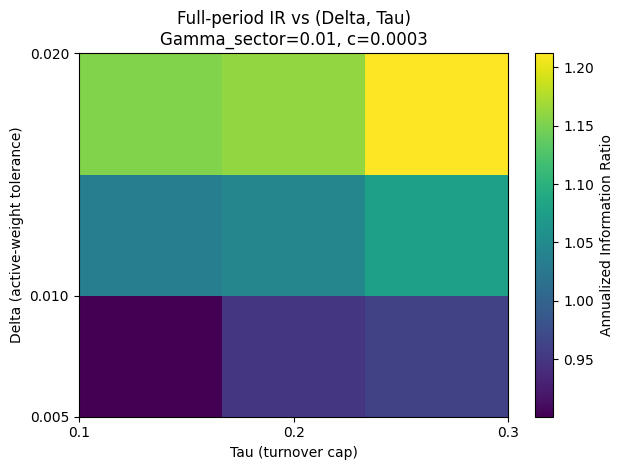

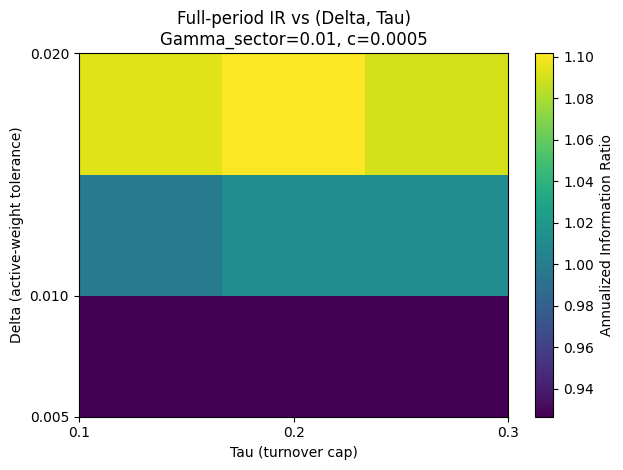

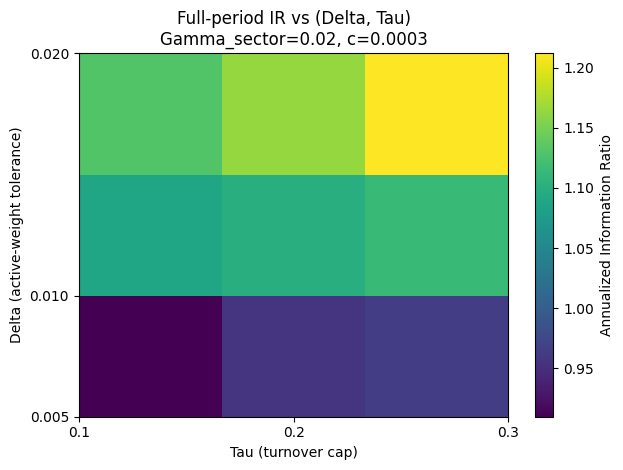

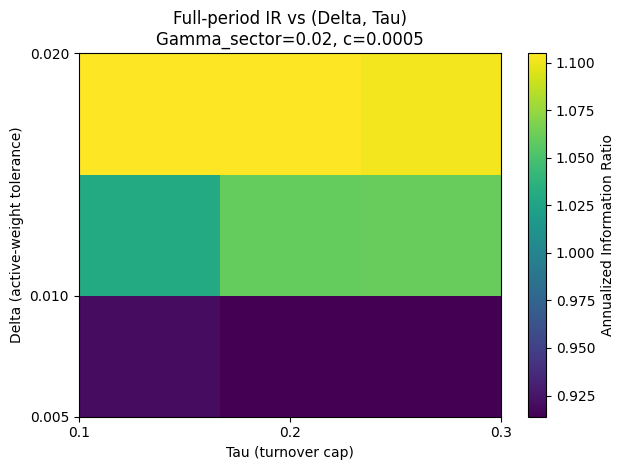

In [ ]:
# generate heatmaps across (delta, tau) for all combinations of (gamma, c)
assert all(col in grid_backtest_df.columns for col in ["delta","tau","gamma_sector","cost_c","ann_IR"])

for gamma in sorted(grid_backtest_df["gamma_sector"].unique()):
    for c in sorted(grid_backtest_df["cost_c"].unique()):
        sub = grid_backtest_df[
            grid_backtest_df["gamma_sector"].eq(gamma) &
            grid_backtest_df["cost_c"].eq(c)
        ]
        if sub.empty:
            continue

        heat = sub.pivot(index="delta", columns="tau", values="ann_IR")

        plt.figure()
        im = plt.imshow(heat.values, aspect="auto", origin="lower",
                        extent=[heat.columns.min(), heat.columns.max(),
                                heat.index.min(),   heat.index.max()])
        plt.colorbar(im, label="Annualized Information Ratio")
        plt.title(f"Full-period IR vs (Delta, Tau)\nGamma_sector={gamma}, c={c}")
        plt.xlabel("Tau (turnover cap)")
        plt.ylabel("Delta (active-weight tolerance)")
        plt.xticks(sorted(heat.columns))
        plt.yticks(sorted(heat.index))
        plt.tight_layout()
        plt.show()


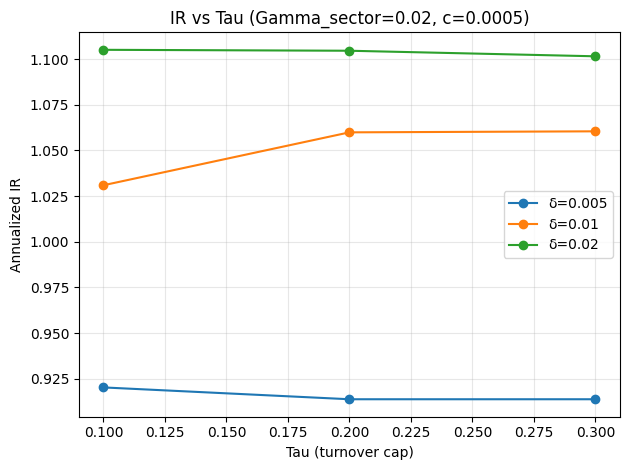

In [ ]:
# Comparison plot1: IR vs Tau for fixed gamma_sector and cost_c
gamma_fix = 0.02
c_fix     = 0.0005

sub = grid_backtest_df[
    (grid_backtest_df["gamma_sector"] == gamma_fix) &
    (grid_backtest_df["cost_c"] == c_fix)
]

plt.figure()
for delta in sorted(sub["delta"].unique()):
    sub_d = sub[sub["delta"] == delta].sort_values("tau")
    plt.plot(sub_d["tau"], sub_d["ann_IR"], marker="o", label=f"δ={delta}")

plt.xlabel("Tau (turnover cap)")
plt.ylabel("Annualized IR")
plt.title(f"IR vs Tau (Gamma_sector={gamma_fix}, c={c_fix})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


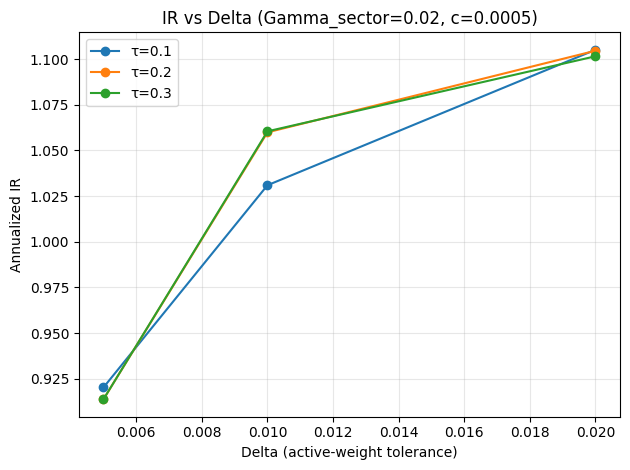

In [ ]:
# Comparison plot2: IR vs Delta for fixed gamma_sector and cost_c
plt.figure()
for tau in sorted(sub["tau"].unique()):
    sub_t = sub[sub["tau"] == tau].sort_values("delta")
    plt.plot(sub_t["delta"], sub_t["ann_IR"], marker="o", label=f"τ={tau}")

plt.xlabel("Delta (active-weight tolerance)")
plt.ylabel("Annualized IR")
plt.title(f"IR vs Delta (Gamma_sector={gamma_fix}, c={c_fix})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


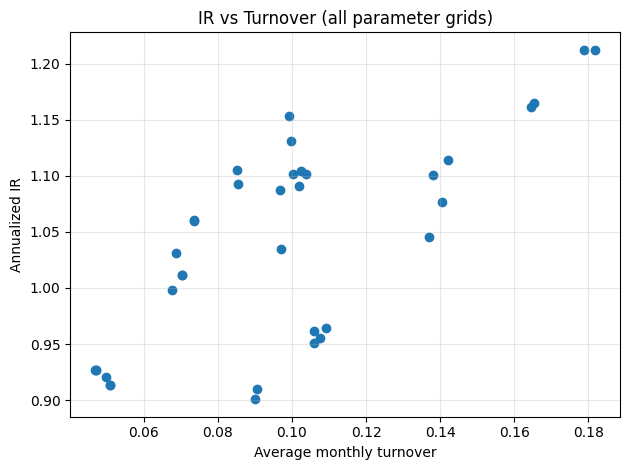

In [ ]:
# Comparison plot3: IR vs Turnover for all grid points
plt.figure()
plt.scatter(grid_backtest_df["avg_turnover"], grid_backtest_df["ann_IR"])

plt.xlabel("Average monthly turnover")
plt.ylabel("Annualized IR")
plt.title("IR vs Turnover (all parameter grids)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Top 3:


,delta,tau,gamma_sector,cost_c,ann_return,ann_vol,ann_IR,avg_turnover,med_turnover,avg_max_sector_dev,max_sector_dev_all,avg_num_bounds,n_months
34,0.02,0.3,0.02,0.0003,0.232888,0.192114,1.212239,0.181781,0.160736,0.02,0.02,450.541667,48
32,0.02,0.3,0.01,0.0003,0.232877,0.192134,1.212056,0.178679,0.167356,0.01,0.01,445.083333,48
30,0.02,0.2,0.02,0.0003,0.229161,0.196805,1.164405,0.165310,0.198688,0.02,0.02,429.500000,48


Bottom 3:


,delta,tau,gamma_sector,cost_c,ann_return,ann_vol,ann_IR,avg_turnover,med_turnover,avg_max_sector_dev,max_sector_dev_all,avg_num_bounds,n_months
11,0.005,0.3,0.02,0.0005,0.162204,0.177496,0.913846,0.050790,0.046928,0.02,0.02,281.083333,48
2,0.005,0.1,0.02,0.0003,0.156288,0.171818,0.909615,0.090470,0.100000,0.02,0.02,366.895833,48
0,0.005,0.1,0.01,0.0003,0.153865,0.170809,0.900803,0.090154,0.100000,0.01,0.01,358.687500,48


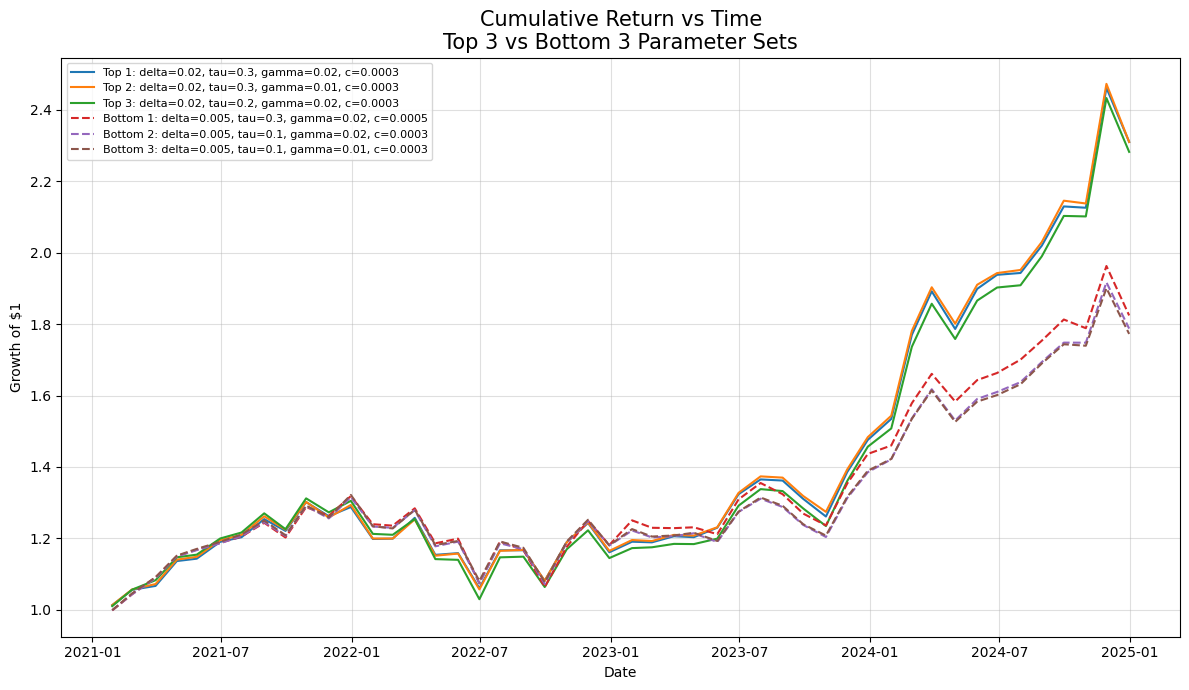

In [ ]:
# plot top 3 vs bottom 3 cumulative return curves

def load_cumulative_from_saved(delta, tau, gamma_sector, c):
    """
    Loads perf_full_period.csv for a given parameter combination
    and returns the cumulative return Series.
    """

    folder = f"results/delta={delta}_tau={tau}_gamma={gamma_sector}_c={c}"
    path = f"{folder}/perf_full_period.csv"

    df = pd.read_csv(path, parse_dates=["date"])
    df = df.set_index("date")

    return df["cum_ret"]

# Select Top/Bottom 3
sorted_df = grid_backtest_df.sort_values("ann_IR", ascending=False)
top3 = sorted_df.head(3)
bottom3 = sorted_df.tail(3)

print("Top 3:")
display(top3)
print("Bottom 3:")
display(bottom3)


# Plot cumulative return curves
plt.figure(figsize=(12, 7))
# Top 3
for rank, (idx, row) in enumerate(top3.iterrows(),start=1):
    cum = load_cumulative_from_saved(
        delta=row["delta"],
        tau=row["tau"],
        gamma_sector=row["gamma_sector"],
        c=row["cost_c"]
    )
    label = f"Top {rank}: delta={row['delta']}, tau={row['tau']}, gamma={row['gamma_sector']}, c={row['cost_c']}"
    plt.plot(cum.index, cum.values, label=label)
# Bottom 3
for rank, (idx, row) in enumerate(bottom3.iterrows(),start=1):
    cum = load_cumulative_from_saved(
        delta=row["delta"],
        tau=row["tau"],
        gamma_sector=row["gamma_sector"],
        c=row["cost_c"]
    )
    label = f"Bottom {rank}: delta={row['delta']}, tau={row['tau']}, gamma={row['gamma_sector']}, c={row['cost_c']}"
    plt.plot(cum.index, cum.values, "--", label=label)

plt.title("Cumulative Return vs Time\nTop 3 vs Bottom 3 Parameter Sets", fontsize=15)
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(True, alpha=0.4)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


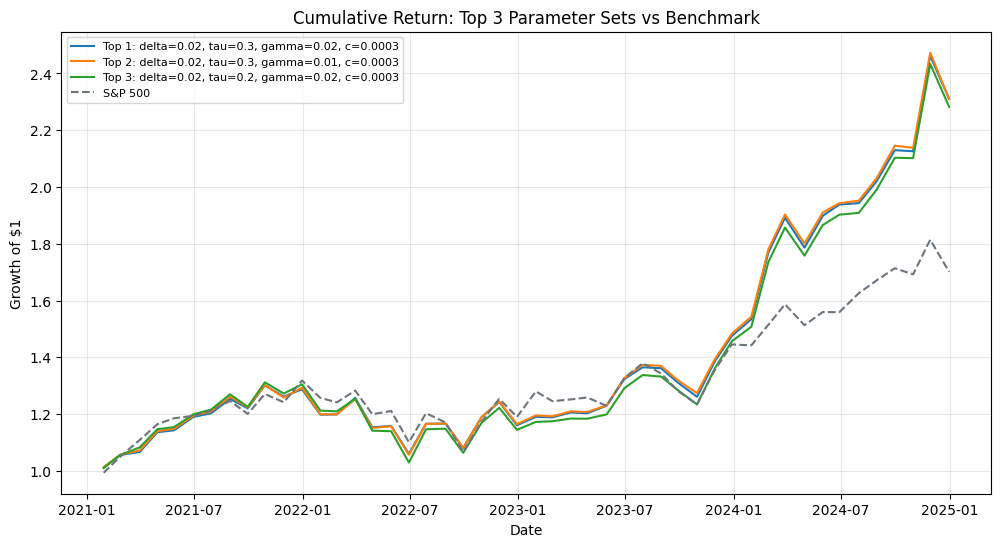

In [ ]:
# Cumulative return plot: Top 3 vs Benchmark

sorted_df = grid_backtest_df.sort_values("ann_IR", ascending=False)
top3 = sorted_df.head(3)
plt.figure(figsize=(12, 6))

for rank, (idx, row) in enumerate(top3.iterrows(), start=1):
    cum = load_cumulative_from_saved(
        delta=row["delta"],
        tau=row["tau"],
        gamma_sector=row["gamma_sector"],
        c=row["cost_c"]
    )
    label = f"Top {rank}: delta={row['delta']}, tau={row['tau']}, gamma={row['gamma_sector']}, c={row['cost_c']}"
    plt.plot(cum.index, cum.values, label=label)

plt.plot(
    bench_cum.index,
    bench_cum.values,
    color="#6c757d", linestyle="--",
    label="S&P 500"
)

plt.title("Cumulative Return: Top 3 Parameter Sets vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.show()


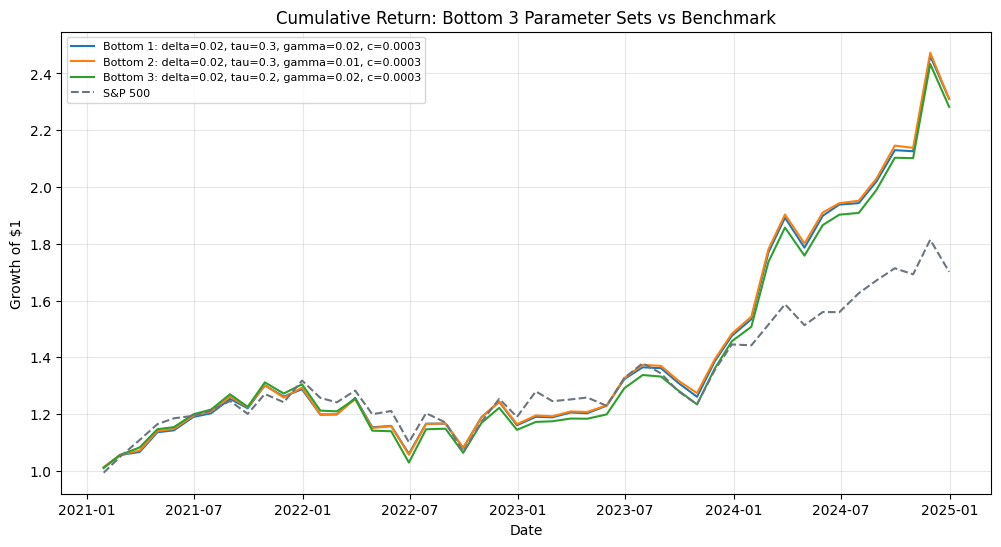

In [ ]:
# Cumulative return plot: Bottom 3 vs Benchmark

bottom3 = sorted_df.tail(3)
plt.figure(figsize=(12, 6))


for rank, (idx, row) in enumerate(top3.iterrows(), start=1):
    cum = load_cumulative_from_saved(
        delta=row["delta"],
        tau=row["tau"],
        gamma_sector=row["gamma_sector"],
        c=row["cost_c"]
    )
    label = f"Bottom {rank}: delta={row['delta']}, tau={row['tau']}, gamma={row['gamma_sector']}, c={row['cost_c']}"
    plt.plot(cum.index, cum.values, linestyle="-", label=label)

plt.plot(
    bench_cum.index,
    bench_cum.values,
    color="#6c757d",
    linestyle="--",
    label="S&P 500"
)

plt.title("Cumulative Return: Bottom 3 Parameter Sets vs Benchmark")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.grid(alpha=0.3)
plt.legend(fontsize=8)
plt.show()
